In [ ]:
pip install image_slicer


In [70]:
import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

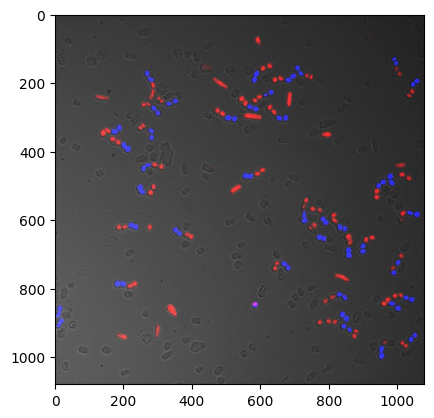

In [222]:
raw = cv2.imread("/Users/aaditmahajan/Documents/segregation_data/images/train/Picture_1.jpg")
plt.imshow(raw)
plt.show()
img = cv2.imread("/Users/aaditmahajan/Documents/segregation_data/images/train/Picture_1.jpg", cv2.IMREAD_GRAYSCALE)
# plt.imshow(img, cmap='gray')
# plt.show()


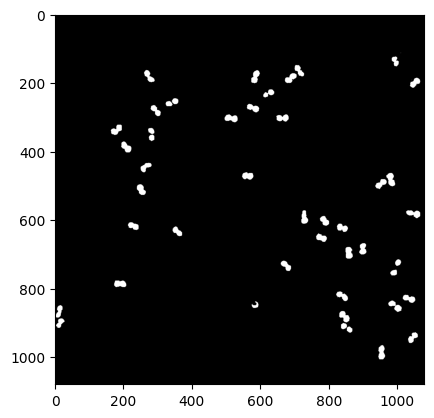

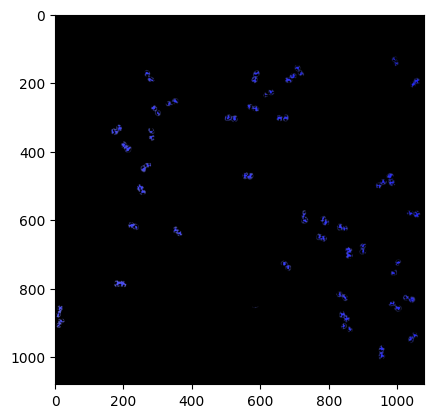

In [154]:
# blue spores isolated
hsv = cv2.cvtColor(raw, cv2.COLOR_BGR2HSV)

result = raw.copy()
lower1 = np.array([0, 100, 20])
upper1 = np.array([10, 255, 255])

lower2 = np.array([160,100,20])
upper2 = np.array([179,255,255])
 
lower_mask = cv2.inRange(hsv, lower1, upper1)
upper_mask = cv2.inRange(hsv, lower2, upper2)

full_mask = lower_mask + upper_mask

result_blue = cv2.bitwise_and(result, result, mask = lower_mask)

plt.imshow(full_mask, cmap = 'gray')
plt.show()
plt.imshow(result_blue, cmap = 'gray')
plt.show()



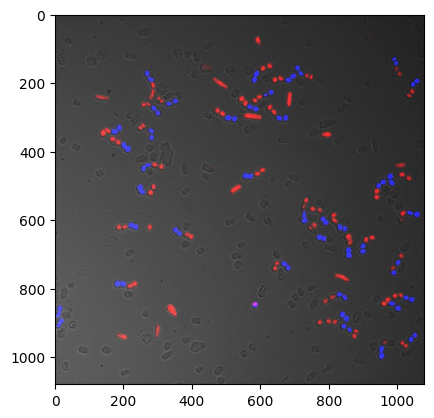

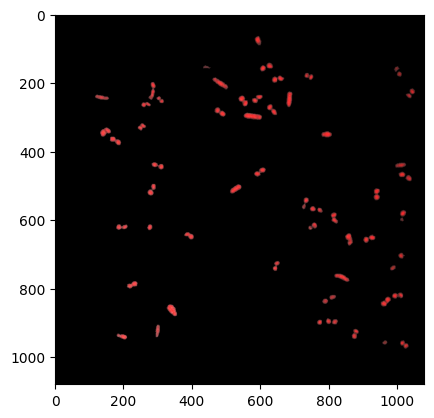

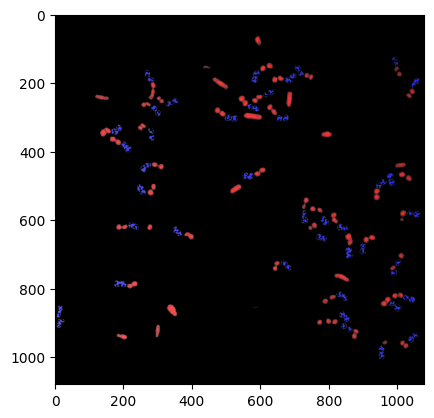

In [155]:
#blue mask - red spores isolated
lower_blue = np.array([100, 100, 20])
upper_blue = np.array([140, 255, 255])

mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)

result_red = cv2.bitwise_and(raw, raw, mask = mask_blue)
spores = result_red + result_blue

plt.imshow(raw, cmap = 'gray')
plt.show()
plt.imshow(result_red, cmap = 'gray')
plt.show()

plt.imshow(spores, cmap='gray')
plt.show()

In [ ]:
# pink spores isolation

lower_pink = np.array([100, 100, 20])
upper_pink = np.array([140, 255, 255])

mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)

result_red = cv2.bitwise_and(raw, raw, mask = mask_blue)

In [230]:
# red_channel = raw[:, :, 0]
# blue_channel = raw[:, :, 2]
# # plt.imshow(red_channel, cmap = 'gray')
# # plt.show()
# # plt.imshow(blue_channel, cmap = 'gray')
# # plt.show()

# mem_only = raw[:, :, 1]
# # spores = red_channel + blue_channel

# # check = blue_channel - red_channel

plt.imshow(raw[:, :, 1], cmap='gray')
plt.show()
cell = raw[:, :, 1]

SyntaxError: invalid syntax (1812468403.py, line 17)

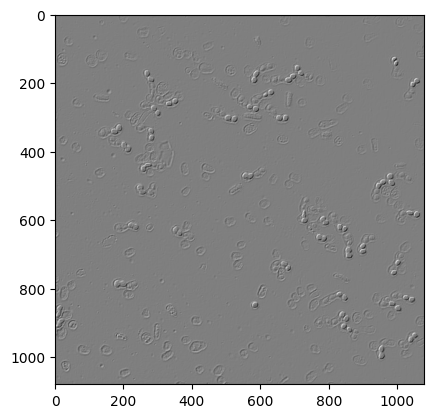

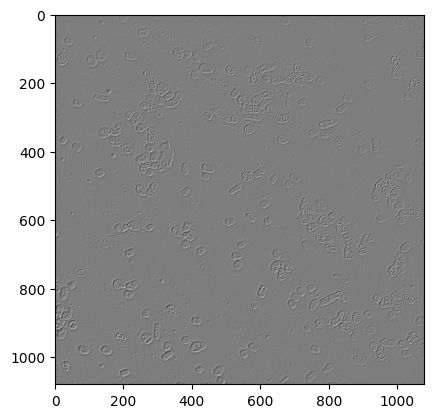

In [231]:
# edge detection of spores 
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)

temp = sobelx + sobely

plt.imshow(temp, cmap='gray')
plt.show()

#edge detection of the cells 
sobelxc = cv2.Sobel(cell,cv2.CV_64F,1,0,ksize=5)
sobelyc = cv2.Sobel(cell,cv2.CV_64F,0,1,ksize=5)
tempc = sobelxc + sobelyc
plt.imshow(tempc, cmap='gray')
plt.show()


Spore grayscale conversion for thresholding 

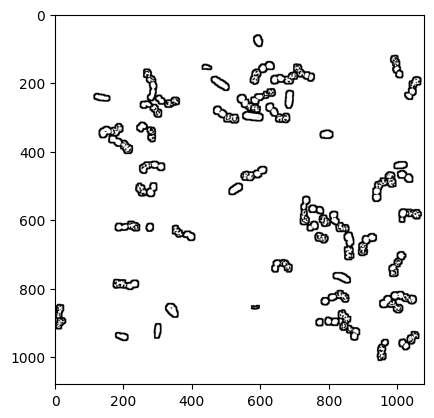

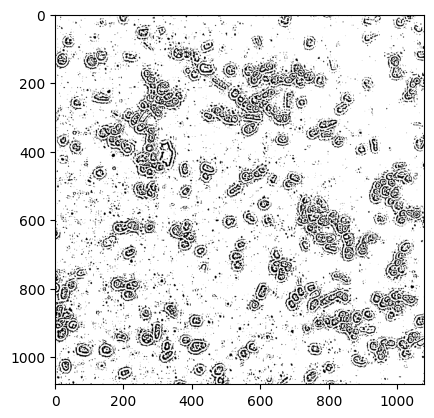

In [232]:
spores_grayscale = cv2.cvtColor(cv2.cvtColor(spores, cv2.COLOR_BGR2HSV), cv2.COLOR_BGR2GRAY)

th2 = cv2.adaptiveThreshold(spores_grayscale,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
cell_th = cv2.adaptiveThreshold(cell,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
# ret,th1 = cv2.threshold(spores_grayscale,127,255, cv2.THRESH_BINARY_INV)
spore_bounds = th2
plt.imshow(th2, cmap='gray')
plt.show()
plt.imshow(cell_th, cmap='gray')
plt.show()


Storing red and blue spore position information. 
Need it for correlating the positions when checking for accuracy. 

In [159]:
red_channel = result_red
blue_channel = result_blue

r_spore_gray = cv2.cvtColor(cv2.cvtColor(red_channel, cv2.COLOR_BGR2HSV), cv2.COLOR_BGR2GRAY)
b_spore_gray = cv2.cvtColor(cv2.cvtColor(blue_channel, cv2.COLOR_BGR2HSV), cv2.COLOR_BGR2GRAY)

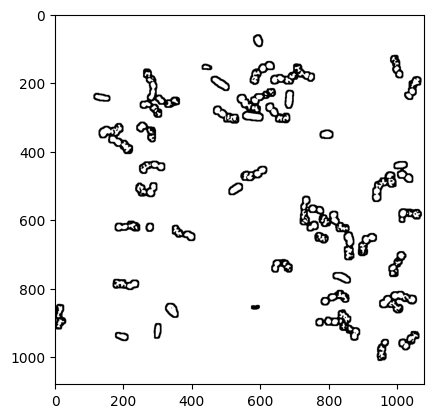

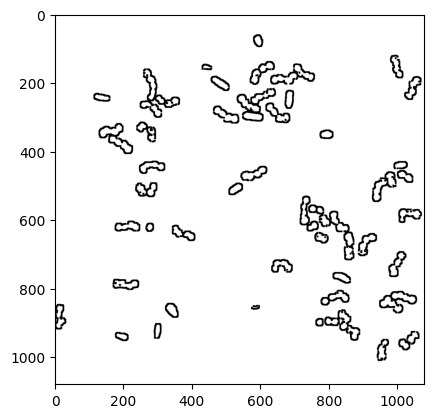

In [216]:
spore_bounds_blur = cv2.medianBlur(spore_bounds, 5)

plt.imshow(spore_bounds_blur, cmap='gray')
plt.show()

erosion = np.array(
    [   [1, 1, 1, 1, 1], 
        [1, 1, 1, 1, 1],
        [1, 1, 1 ,1, 1],
        [1, 1, 1, 1, 1], 
        [1, 1, 1, 1, 1]
        ]
)

# dilation function is having the effect of what erosion should have and vice versa. idk why

# thin_bounds = cv2.dilate(spore_bounds, kernel=erosion, iterations= 1)

for erode_iter in range(0, 3):
    thick_bounds = cv2.erode(cv2.dilate(spore_bounds, kernel=erosion, iterations= 1), kernel=erosion, iterations= 1)

thin_bounds = cv2.dilate(thick_bounds, kernel = erosion, iterations = 1)
plt.imshow(thick_bounds, cmap='gray')
plt.show()

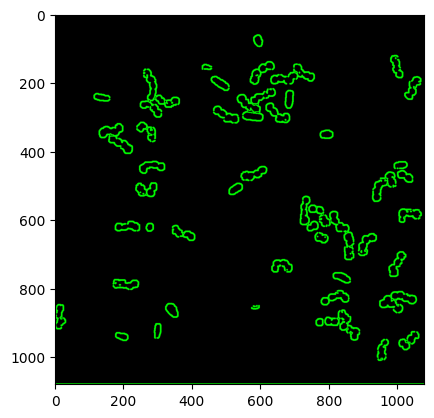

['no.of bodies = ', 2243]


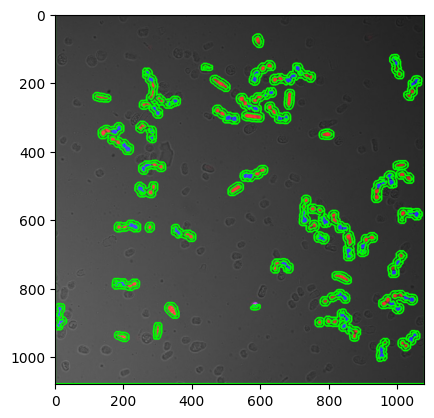

In [219]:
contours, hierarchy = cv2.findContours(thin_bounds, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
drawing = np.zeros((thin_bounds.shape[0], thin_bounds.shape[1], 3), dtype=np.uint8)
for i in range(len(contours)):
    cv2.drawContours(drawing, contours, i, [0, 255, 0], 2, cv2.LINE_8, hierarchy, 0)

plt.imshow(drawing, cmap='gray')
plt.show()
print(['no.of bodies = ', len(contours)])
overlay = drawing + raw
plt.imshow(overlay, cmap='gray')
plt.show()





In [245]:
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage as ndi
import argparse
import imutils

# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(thin_bounds)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=thin_bounds)
mask_wts = np.zeros(distance.shape, dtype=bool)
mask_wts[tuple(coords.T)] = True
markers, _ = ndi.label(mask_wts)
labels = watershed(-distance, markers, mask=mask_wts)

plt.imshow("labels")




SyntaxError: invalid syntax (2759212619.py, line 1)